<a href="https://colab.research.google.com/github/yashb98/pytorch/blob/main/Rice_type_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the opendatasets library
!pip install opendatasets --quiet
import opendatasets as od
# Download the rice type classification dataset from Kaggle
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

In [104]:
# Importing necessary libraries from PyTorch
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

# Importing a utility to display model summary
from torchsummary import summary

# Importing tools from scikit-learn for data splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Importing libraries for visualization and data manipulation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Check if a GPU is available and set the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)  # Print the device being used (cuda or cpu)

cuda


In [105]:
# Read the CSV file containing the rice classification dataset into a pandas DataFrame
df = pd.read_csv('/content/rice-type-classification/riceClassification.csv')

# Display the first 5 rows of the DataFrame to get an overview of the data
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [106]:
# Remove any rows in the DataFrame that contain missing (NaN) values
df.dropna(inplace=True)

# Drop the 'id' column from the DataFrame as it is likely not useful for classification
df.drop(['id'], axis=1, inplace=True)

# Display the first 5 rows of the cleaned DataFrame
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [107]:
# Display the column names of the DataFrame
df.columns

Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'EquivDiameter', 'Extent', 'Perimeter', 'Roundness',
       'AspectRation', 'Class'],
      dtype='object')

In [108]:
# Print the number of instances (counts) for each unique class label in the 'Class' column
# This helps to understand the class distribution and check for imbalance in the dataset
print(df['Class'].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [109]:
# Display all unique class labels present in the 'Class' column
# This helps to identify the different rice types/categories in the dataset
df['Class'].unique()

array([1, 0])

In [110]:
# Create a copy of the original DataFrame to preserve the original data for later use or comparison
original_df = df.copy()

# Loop through each column in the DataFrame
for column in df.columns:
  # Normalize each column by dividing its values by the maximum absolute value in that column
  # This scales the data to a range between -1 and 1 (or 0 and 1 if all values are positive)
  df[column] = df[column] / df[column].abs().max()

# Display the first 5 rows of the normalized DataFrame
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [111]:
# Extract all feature columns (i.e., all columns except the last one) and convert them to a NumPy array
X = np.array(df.iloc[:, :-1])

# Extract the target column (i.e., the last column) and convert it to a NumPy array
Y = np.array(df.iloc[:, -1])

In [112]:
# Split the dataset into training and testing sets
# 70% of the data will be used for training and 30% for testing
# 'random_state=42' ensures reproducibility of the split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [113]:
# Further split the original test set into two equal parts: test and validation sets
# 50% of the original test data goes to validation, and 50% remains as the test set
# This results in 15% of the original data for validation and 15% for testing
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

In [114]:
# Print the shape (number of samples and features) of the training set
print(X_train.shape)

# Print the shape of the test set
print(X_test.shape)

# Print the shape of the validation set
print(X_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [115]:
# Custom Dataset class inheriting from PyTorch's Dataset
class dataset(Dataset):

  # Constructor to initialize the dataset with features (X) and labels (Y)
  def __init__(self, X, Y):
    # Convert features to a PyTorch tensor of type float32 and move to the specified device (CPU or GPU)
    self.X = torch.tensor(X, dtype=torch.float32).to(device)
    # Convert labels to a PyTorch tensor of type long (integer class labels) and move to the specified device
    self.Y = torch.tensor(Y, dtype=torch.long).to(device)

  # Return the total number of samples in the dataset
  def __len__(self):
    return len(self.X)

  # Retrieve the feature and label pair at the specified index
  def __getitem__(self, index):
    return self.X[index], self.Y[index]


In [116]:
# Create a dataset object for the training data using the custom Dataset class
training_data = dataset(X_train, Y_train)

# Create a dataset object for the testing data
testing_data = dataset(X_test, Y_test)

# Create a dataset object for the validation data
validation_data = dataset(X_val, Y_val)

In [117]:
# Create a DataLoader for the training dataset
# batch_size=32 means data will be loaded in batches of 32 samples
# shuffle=True ensures data is shuffled every epoch for better training
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)

# Create a DataLoader for the testing dataset with the same batch size and shuffling
test_dataloader = DataLoader(testing_data, batch_size=32, shuffle=True)

# Create a DataLoader for the validation dataset with the same batch size and shuffling
validate_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)

In [118]:
# Iterate over the training DataLoader to get one batch of data
for x, y in train_dataloader:
  # Print the batch of feature tensors
  print(x)
  print("#################")
  # Print the corresponding batch of labels
  print(y)
  # Break after the first batch to avoid printing the entire dataset
  break

tensor([[0.9959, 0.9110, 0.9505, 0.9129, 0.9425, 0.9979, 0.8911, 0.7889, 0.8775,
         0.5438],
        [0.5451, 0.8072, 0.5967, 0.9753, 0.5211, 0.7383, 0.5154, 0.6555, 0.6957,
         0.7675],
        [0.7441, 0.8120, 0.7994, 0.9270, 0.7106, 0.8626, 0.8040, 0.6965, 0.8412,
         0.5763],
        [0.5568, 0.8065, 0.6035, 0.9738, 0.5308, 0.7462, 0.5389, 0.6544, 0.7131,
         0.7581],
        [0.5978, 0.8708, 0.6013, 0.9830, 0.5675, 0.7732, 0.8226, 0.6936, 0.6815,
         0.8216],
        [0.8433, 0.8566, 0.8577, 0.9231, 0.8020, 0.9183, 0.6551, 0.7374, 0.8504,
         0.5666],
        [0.7796, 0.8391, 0.8135, 0.9304, 0.7453, 0.8830, 0.8092, 0.7187, 0.8278,
         0.5852],
        [0.4210, 0.5899, 0.6243, 0.9092, 0.3984, 0.6488, 0.6756, 0.5099, 0.8880,
         0.5361],
        [0.5332, 0.8255, 0.5655, 0.9839, 0.5054, 0.7302, 0.5226, 0.6483, 0.6957,
         0.8282],
        [0.6361, 0.9050, 0.6131, 0.9850, 0.6045, 0.7976, 0.5375, 0.7073, 0.6974,
         0.8375],
        [0

In [119]:
# Define the number of neurons in the hidden layer
HIDDEN_NEURONS = 10

# Define a custom neural network model by subclassing nn.Module
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()

    # Input layer: fully connected layer from input features to hidden neurons
    # X.shape[1] is the number of input features
    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)

    # Output layer: fully connected layer from hidden neurons to 1 output neuron
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)

    # Sigmoid activation to squash output between 0 and 1 (useful for binary classification)
    self.sigmoid = nn.Sigmoid()

  # Define the forward pass through the network
  def forward(self, x):
    x = self.input_layer(x)  # Pass input through the input layer
    x = self.linear(x)       # Pass result through the output layer
    x = self.sigmoid(x)      # Apply sigmoid activation to output
    return x                 # Return the final output

# Instantiate the model and move it to the device (CPU or GPU)
model = MyModel().to(device)

In [120]:
# Print a summary of the model architecture
# (X.shape[1],) specifies the shape of a single input sample (number of features)
# This shows layer details, output shapes, and number of parameters
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [121]:
# Define the loss function as Binary Cross Entropy Loss (BCELoss)
# Suitable for binary classification tasks with sigmoid output
criterion = nn.BCELoss()

# Define the optimizer as Adam, which adapts the learning rate during training
# Pass the model parameters to optimize and set the learning rate to 0.001
optimizer = Adam(model.parameters(), lr=0.001)

In [122]:
# Lists to store loss and accuracy values for plotting later
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_val_plot = []
total_acc_train_plot = []

# Number of epochs (full passes over the training data)
epochs = 10

# Start training loop
for epoch in range(epochs):
  # Initialize accumulators for loss and accuracy for this epoch
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  # Training phase - iterate over batches of training data
  for data in train_dataloader:
    input, labels = data  # Get features and labels batch

    # Forward pass: get model predictions, squeeze removes extra dimension
    predictions = model(input).squeeze(1)

    # Convert labels to float tensor (required by BCELoss)
    labels = labels.float()

    # Compute loss between predictions and true labels
    batch_loss = criterion(predictions, labels)
    total_loss_train += batch_loss.item()  # Accumulate loss

    # Calculate batch accuracy by rounding predictions to 0 or 1 and comparing to labels
    acc = ((predictions).round() == labels).sum().item()
    total_acc_train += acc  # Accumulate correct predictions count

    # Backpropagation: compute gradients
    batch_loss.backward()

    # Update model parameters based on gradients
    optimizer.step()

    # Zero the gradients before the next batch to avoid accumulation
    optimizer.zero_grad()

  # Validation phase - no gradient computation for efficiency
  with torch.no_grad():
    for data in validate_dataloader:
      input, labels = data
      predictions = model(input).squeeze(1)
      labels = labels.float()
      batch_loss = criterion(predictions, labels)
      total_loss_val += batch_loss.item()

      acc = ((predictions).round() == labels).sum().item()
      total_acc_val += acc

  # Append average loss and accuracy for train and validation sets for plotting
  total_loss_train_plot.append(round(total_loss_train / 1000, 4))
  total_loss_val_plot.append(round(total_loss_val / 1000, 4))

  total_acc_train_plot.append(round(total_acc_train / training_data.__len__() * 100, 4))
  total_acc_val_plot.append(round(total_acc_val / validation_data.__len__() * 100, 4))

  # Print epoch statistics: train and validation loss and accuracy
  print(f'''Epoch number: {epoch+1} Train Loss: {round(total_loss_train / 1000, 4)}
    Train Accuracy {round(total_acc_train / training_data.__len__() * 100, 4)}
    Validation Loss: {round(total_loss_val / 1000, 4)}
    Validation Accuracy: {round(total_acc_val / validation_data.__len__() * 100, 4)}
          ''')

Epoch number: 1 Train Loss: 0.2539 
    Train Accuracy 73.6979 
    Validation Loss: 0.4388
    Validation Accuracy: 97.5806      
          
Epoch number: 2 Train Loss: 0.135 
    Train Accuracy 97.7767 
    Validation Loss: 0.1765
    Validation Accuracy: 98.3871      
          
Epoch number: 3 Train Loss: 0.061 
    Train Accuracy 98.2481 
    Validation Loss: 0.0946
    Validation Accuracy: 98.5704      
          
Epoch number: 4 Train Loss: 0.0382 
    Train Accuracy 98.3738 
    Validation Loss: 0.0682
    Validation Accuracy: 98.5337      
          
Epoch number: 5 Train Loss: 0.0292 
    Train Accuracy 98.5073 
    Validation Loss: 0.0547
    Validation Accuracy: 98.607      
          
Epoch number: 6 Train Loss: 0.0246 
    Train Accuracy 98.5545 
    Validation Loss: 0.0483
    Validation Accuracy: 98.5704      
          
Epoch number: 7 Train Loss: 0.022 
    Train Accuracy 98.5545 
    Validation Loss: 0.0441
    Validation Accuracy: 98.607      
          
Epoch numbe

In [123]:
# Disable gradient calculation for evaluation (saves memory and computations)
with torch.no_grad():
  total_loss_test = 0  # Accumulator for test loss
  total_acc_test = 0   # Accumulator for test accuracy (correct predictions)

  # Iterate over batches in the test DataLoader
  for data in test_dataloader:
    input, labels = data  # Get features and labels

    # Forward pass to get predictions and remove extra dimension
    predictions = model(input).squeeze(1)

    # Convert labels to float for loss calculation
    labels = labels.float()

    # Compute batch loss and add to total test loss
    batch_loss = criterion(predictions, labels).item()
    total_loss_test += batch_loss

    # Calculate batch accuracy by rounding predictions and comparing with labels
    acc = ((predictions).round() == labels).sum().item()
    total_acc_test += acc

# Print overall test accuracy as a percentage of correctly predicted samples
print(f"Accuracy: {round(total_acc_test / testing_data.__len__() * 100, 4)}")

# Print average test loss scaled by the number of samples (multiplied by 100, adjust if needed)
print(f"Loss: {round(total_loss_test / testing_data.__len__() * 100, 4)}")

Accuracy: 98.9003
Loss: 0.115


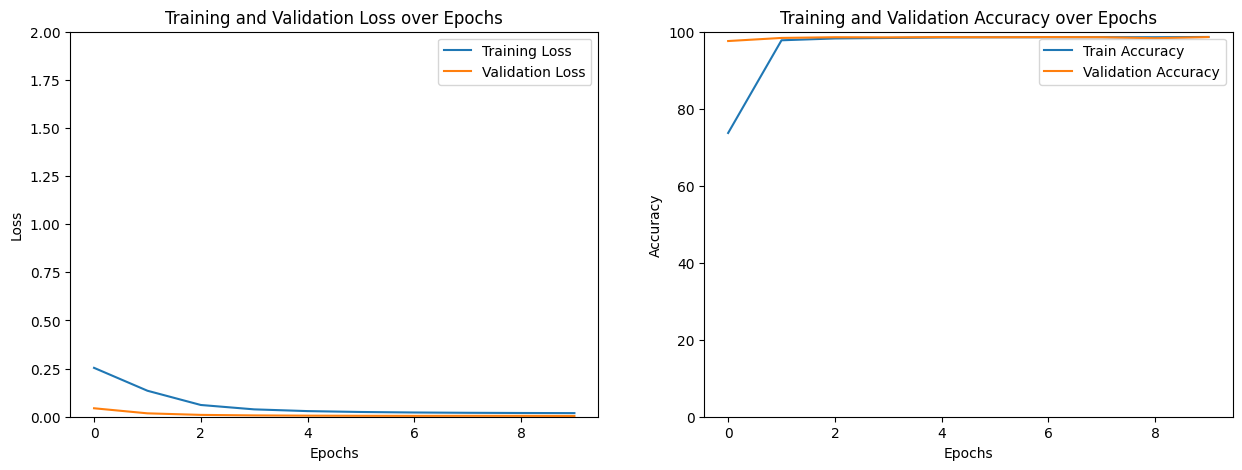

In [124]:
# Create a figure with 1 row and 2 columns of subplots, size 15x5 inches
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot training and validation loss on the first subplot (left)
axs[0].plot(total_loss_train_plot, label='Training Loss')   # Training loss curve
axs[0].plot(total_loss_val_plot, label='Validation Loss')   # Validation loss curve
axs[0].set_title('Training and Validation Loss over Epochs') # Title of the plot
axs[0].set_xlabel('Epochs')                                 # X-axis label
axs[0].set_ylabel('Loss')                                   # Y-axis label
axs[0].set_ylim([0, 2])                                     # Set y-axis limits for better visualization
axs[0].legend()                                             # Show legend for curves

# Plot training and validation accuracy on the second subplot (right)
axs[1].plot(total_acc_train_plot, label='Train Accuracy')    # Training accuracy curve
axs[1].plot(total_acc_val_plot, label='Validation Accuracy') # Validation accuracy curve
axs[1].set_title('Training and Validation Accuracy over Epochs') # Title of the plot
axs[1].set_xlabel('Epochs')                                 # X-axis label
axs[1].set_ylabel('Accuracy')                               # Y-axis label
axs[1].set_ylim([0, 100])                                   # Set y-axis limits to percentage range (0 to 100)
axs[1].legend()                                             # Show legend for curves

# Display the plots
plt.show()

In [125]:
# Print the list of validation losses recorded after each epoch
print(total_loss_val_plot)

# Print the list of validation accuracies recorded after each epoch
print(total_acc_val_plot)

[0.0439, 0.0176, 0.0095, 0.0068, 0.0055, 0.0048, 0.0044, 0.0047, 0.0045, 0.0039]
[97.5806, 98.3871, 98.5704, 98.5337, 98.607, 98.5704, 98.607, 98.5704, 98.3138, 98.607]


In [127]:
# Display the first few rows of the original (unnormalized) dataframe
original_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [131]:
# Normalize each feature value by dividing the given constant by the maximum absolute value
# of that feature in the original (unnormalized) dataframe to scale it similarly to training data

area = 2353 / original_df['Area'].abs().max()
MajorAxisLength = 81 / original_df['MajorAxisLength'].abs().max()
MinorAxisLength = 42 / original_df['MinorAxisLength'].abs().max()
Eccentricity = 32 / original_df['Eccentricity'].abs().max()
ConvexArea = 12 / original_df['ConvexArea'].abs().max()
EquivDiameter = 33 / original_df['EquivDiameter'].abs().max()
Extent = 98 / original_df['Extent'].abs().max()
Perimeter = 927 / original_df['Perimeter'].abs().max()
Roundness = 677 / original_df['Roundness'].abs().max()
AspectRation = 24 / original_df['AspectRation'].abs().max()

# Create a tensor from the normalized feature values, convert it to float32, and move it to the correct device (CPU/GPU)
input_tensor = torch.tensor(
    [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation],
    dtype=torch.float32
).to(device)

# Use the trained model to predict the class for the input features
my_prediction = model(input_tensor)


In [133]:
# Extract the scalar value (prediction) from the single-element tensor output by the model
my_prediction.item()

0.0